# DistilBERT model
This notebook trains the DistilBERT model and exports a set of predictions for a test dataset.

**Trains on:** SemEval (2019)

First we need to install the required packages.

In [12]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [13]:
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [14]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [15]:
!pip install tweet-preprocessor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [16]:
from google.colab import drive

# Mount drive for loading the data
drive.mount('/content/drive')

import sys
sys.path.append("drive/MyDrive/Colab Notebooks")

from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments, DistilBertTokenizer
import numpy as np
from datasets import load_metric, load_dataset, Dataset
from sklearn.model_selection import train_test_split
import pickle
import torch
from google.colab import drive
import preprocessor as p
import html
from torch.utils.data import DataLoader
import torch.nn.functional as nn
from reader import Reader

FILENAME = "drive/MyDrive/Colab Notebooks/data/sem_eval_all.pkl"
NUM_LABELS = 2
BATCH_SIZE = 128
NUM_EPOCHS = 5

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Split and tokenize the datasets

In [17]:
class HateDataset(torch.utils.data.Dataset):
    """Dataset class used for combining the data encodings and labels."""
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

def preprocess(data):
    """Preprocesses the data by tokenizing URLs and MENTIONS since these do not
    contain any valuable information."""
    p.set_options(p.OPT.URL, p.OPT.MENTION)

    return list(map(lambda text: p.tokenize(html.unescape(text)), data))

In [18]:
reader = Reader(filename=FILENAME)
X, y = reader.load()
X = preprocess(X)

mapping = {'hate': 1, 'none': 0}
y = [mapping[b] for b in y]

# Split dataset into train, test, and validation
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10, stratify=y, test_size=0.10)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=10, test_size=.2)
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

# Tokenize all datasets
train_encodings = tokenizer(X_train, truncation=True, padding=True)
val_encodings = tokenizer(X_val, truncation=True, padding=True)
test_encodings = tokenizer(X_test, truncation=True, padding=True)

# Combine the encodings with the labels to Torch datasets
train_dataset = HateDataset(train_encodings, y_train)
val_dataset = HateDataset(val_encodings, y_val)
test_dataset = HateDataset(test_encodings, y_test)

loading file https://huggingface.co/distilbert-base-uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/0e1bbfda7f63a99bb52e3915dcf10c3c92122b827d92eb2d34ce94ee79ba486c.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/distilbert-base-uncased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/distilbert-base-uncased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/distilbert-base-uncased/resolve/main/tokenizer_config.json from cache at /root/.cache/huggingface/transformers/8c8624b8ac8aa99c60c912161f8332de003484428c47906d7ff7eb7f73eecdbb.20430bd8e10ef77a7d2977accefe796051e01bc2fc4aa146bc862997a1a15e79
loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf

## Load accuracy metric for the model's evaluation

In [19]:
metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

## Setup DistilBERT model

In [20]:
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=NUM_LABELS)
training_args = TrainingArguments(output_dir="train", evaluation_strategy="epoch", per_device_train_batch_size=BATCH_SIZE, num_train_epochs=NUM_EPOCHS)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset ,
    compute_metrics=compute_metrics
)

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.20.1",
  "vocab_size": 30522
}

loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/9c169103d7e5a73936dd2b627e42851bec0831212b677c637033ee4bce9

## Training

In [21]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 8640
  Num Epochs = 5
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 340


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.481421,0.753241
2,No log,0.441610,0.789815
3,No log,0.470808,0.791667
4,No log,0.524515,0.788889
5,No log,0.565094,0.793981


***** Running Evaluation *****
  Num examples = 2160
  Batch size = 8
***** Running Evaluation *****
  Num examples = 2160
  Batch size = 8
***** Running Evaluation *****
  Num examples = 2160
  Batch size = 8
***** Running Evaluation *****
  Num examples = 2160
  Batch size = 8
***** Running Evaluation *****
  Num examples = 2160
  Batch size = 8


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=340, training_loss=0.32446915121639475, metrics={'train_runtime': 362.7656, 'train_samples_per_second': 119.085, 'train_steps_per_second': 0.937, 'total_flos': 1978317806803200.0, 'train_loss': 0.32446915121639475, 'epoch': 5.0})

In [22]:
path = F"drive/MyDrive/Colab Notebooks/output/distilbert-semeval.pth" 
torch.save(model, path)

In [23]:
model = torch.load(path)

## Model calibration
We use temperature scaling to calibrate the model on the validation set by finding the optimal T value.

In [24]:
import sys
sys.path.append("drive/MyDrive/Colab Notebooks")
from temperature_scaling import ModelWithTemperature


In [25]:
calibrated_model = ModelWithTemperature(model)
val_loader = DataLoader(val_dataset)

# Find optimal T value to calibrate the model
calibrated_model.set_temperature(val_loader)


Before temperature - NLL: 0.651, ECE: 0.155
Optimal temperature: 1.646
After temperature - NLL: 0.564, ECE: 0.104


ModelWithTemperature(
  (model): DistilBertForSequenceClassification(
    (distilbert): DistilBertModel(
      (embeddings): Embeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (transformer): Transformer(
        (layer): ModuleList(
          (0): TransformerBlock(
            (attention): MultiHeadSelfAttention(
              (dropout): Dropout(p=0.1, inplace=False)
              (q_lin): Linear(in_features=768, out_features=768, bias=True)
              (k_lin): Linear(in_features=768, out_features=768, bias=True)
              (v_lin): Linear(in_features=768, out_features=768, bias=True)
              (out_lin): Linear(in_features=768, out_features=768, bias=True)
            )
            (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (

## Export model

In [26]:
path = F"drive/MyDrive/Colab Notebooks/output/distilbert-semeval-calibrated.pth" 
torch.save(calibrated_model, path)

In [27]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

logits = []
labels = []

test_loader = DataLoader(test_dataset)

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        label = batch['labels'].to(device)
        outputs = calibrated_model(input_ids, attention_mask=attention_mask)
        logits.append(outputs.tolist()[0])
        labels.append(label)

probabilities = nn.softmax(torch.tensor(logits), dim=1)
print(probabilities.tolist()[:10])

[[0.9735488295555115, 0.02645118348300457], [0.8830448389053345, 0.11695511639118195], [0.9253570437431335, 0.07464297860860825], [0.30723127722740173, 0.6927687525749207], [0.7239320874214172, 0.27606794238090515], [0.7789956331253052, 0.2210044413805008], [0.9693713188171387, 0.03062872402369976], [0.6045182943344116, 0.395481675863266], [0.9589912295341492, 0.04100877791643143], [0.11887717247009277, 0.8811227679252625]]


In [28]:
predictions = torch.argmax(probabilities, dim=-1)
metric = load_metric("accuracy")
accuracy = metric.compute(predictions=predictions, references=labels)
print("Test dataset: ", accuracy)

Test dataset:  {'accuracy': 0.7683333333333333}


[[0.9735488295555115, 0.02645118348300457], [0.8830448389053345, 0.11695511639118195], [0.9253570437431335, 0.07464297860860825], [0.30723127722740173, 0.6927687525749207], [0.7239320874214172, 0.27606794238090515], [0.7789956331253052, 0.2210044413805008], [0.9693713188171387, 0.03062872402369976], [0.6045182943344116, 0.395481675863266], [0.9589912295341492, 0.04100877791643143], [0.11887717247009277, 0.8811227679252625], [0.0788465142250061, 0.9211535453796387], [0.09250520914793015, 0.907494843006134], [0.08565063029527664, 0.914349377155304], [0.0860067754983902, 0.913993239402771], [0.2210116684436798, 0.7789883017539978], [0.07419347018003464, 0.9258065223693848], [0.5967610478401184, 0.4032389521598816], [0.33705344796180725, 0.6629465818405151], [0.7232691645622253, 0.27673083543777466], [0.06521182507276535, 0.9347882270812988], [0.9667474627494812, 0.033252473920583725], [0.7568238973617554, 0.24317611753940582], [0.806950032711029, 0.19304998219013214], [0.1079690083861351,

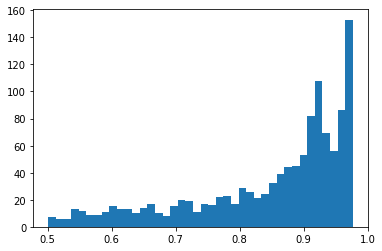

In [29]:
import matplotlib.pyplot as plt
print(probabilities.tolist())
probs = np.max(probabilities.tolist(), axis=1)
print(probs)
plt.hist(probs, bins=40)
plt.show()

In [30]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

logits = []
labels = []

test_loader = DataLoader(test_dataset)

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        label = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        logits.append(outputs.logits.tolist()[0])
        labels.append(label)

probabilities = nn.softmax(torch.tensor(logits), dim=1)
print(probabilities.tolist()[:10])

[[0.9973625540733337, 0.002637393306940794], [0.9653692841529846, 0.03463069722056389], [0.9843889474868774, 0.015611028298735619], [0.20776477456092834, 0.7922351956367493], [0.8301853537559509, 0.1698145866394043], [0.888332188129425, 0.11166775971651077], [0.9966212511062622, 0.003378760302439332], [0.6678536534309387, 0.3321463167667389], [0.9944518208503723, 0.005548164714127779], [0.035662200301885605, 0.9643378257751465]]


In [31]:
predictions = torch.argmax(probabilities, dim=-1)
metric = load_metric("accuracy")
accuracy = metric.compute(predictions=predictions, references=labels)
print("Test dataset: ", accuracy)

Test dataset:  {'accuracy': 0.7683333333333333}


[[0.9973625540733337, 0.002637393306940794], [0.9653692841529846, 0.03463069722056389], [0.9843889474868774, 0.015611028298735619], [0.20776477456092834, 0.7922351956367493], [0.8301853537559509, 0.1698145866394043], [0.888332188129425, 0.11166775971651077], [0.9966212511062622, 0.003378760302439332], [0.6678536534309387, 0.3321463167667389], [0.9944518208503723, 0.005548164714127779], [0.035662200301885605, 0.9643378257751465], [0.017185339704155922, 0.9828146696090698], [0.022780969738960266, 0.9772189855575562], [0.019881105050444603, 0.9801188707351685], [0.020027222111821175, 0.979972779750824], [0.11167464405298233, 0.8883253335952759], [0.015446806326508522, 0.9845532178878784], [0.6559410691261292, 0.34405893087387085], [0.2472149282693863, 0.7527850866317749], [0.8294148445129395, 0.17058517038822174], [0.012332765385508537, 0.9876672029495239], [0.9961163997650146, 0.003883587196469307], [0.8663323521614075, 0.13366763293743134], [0.913288414478302, 0.08671156316995621], [0.0

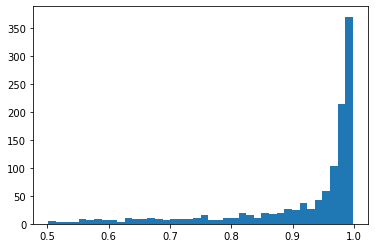

In [32]:
import matplotlib.pyplot as plt
print(probabilities.tolist())
probs = np.max(probabilities.tolist(), axis=1)
print(probs)
plt.hist(probs, bins=40)
plt.show()